In [1]:
# General Utilities
import time
from datetime import datetime
import string
import re
import os
from collections import Counter, defaultdict
import math
import warnings

# Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Modeling and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, accuracy_score, classification_report, root_mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance
from statsmodels.tsa.stattools import grangercausalitytests
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [2]:
# Load cleaned eight_k_sections_df from CSV
daily_sentiment_df = pd.read_csv('daily_sentiment_df.csv')

# Load cleaned daily_data_df from CSV
daily_data_df = pd.read_csv('cleaned_daily_data_df.csv')

In [3]:
# Preview the eight_k_sections_df
print("Daily Sentiment DataFrame:")
daily_sentiment_df

Daily Sentiment DataFrame:


,ticker,disclosure_date,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment
0,AAPL,2023-02-02,0.939026,0.040366,0.020608,0.918418
1,AAPL,2023-03-10,0.900652,0.047103,0.052245,0.848408
2,AAPL,2023-05-04,0.938256,0.041305,0.020439,0.917817
3,AAPL,2023-05-10,0.937492,0.033279,0.029229,0.908264
4,AAPL,2023-08-03,0.940008,0.038987,0.021005,0.919004
...,...,...,...,...,...,...
561,XOM,2024-10-03,0.940580,0.037059,0.022361,0.918220
562,XOM,2024-10-08,0.943406,0.028649,0.027945,0.915461
563,XOM,2024-10-18,0.872158,0.106334,0.021508,0.850649
564,XOM,2024-11-01,0.920774,0.044801,0.034425,0.886348


In [4]:
# Count missing values by column
missing_sent_values_by_column = daily_sentiment_df.isnull().sum()

# Display the count of missing values for each column
print(missing_sent_values_by_column)

ticker                0
disclosure_date       0
positive_sentiment    0
neutral_sentiment     0
negative_sentiment    0
compound_sentiment    0
dtype: int64


In [5]:
# Preview the daily_data_df
print("\nDaily Data DataFrame:")
daily_data_df


Daily Data DataFrame:


,Date,year,month,day,Symbol,Open,High,Low,Close,Volume,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change
0,2024-11-12,2024,11,12,AAPL,224.55,225.5900,223.36,224.23,40375300.0,0,0,1,0,-0.3953,-15.3322
1,2024-11-11,2024,11,11,AAPL,225.00,225.7000,221.50,224.23,41949000.0,0,1,0,1,0.0000,3.8977
2,2024-11-08,2024,11,8,AAPL,227.17,228.6600,226.41,226.96,38308700.0,0,1,1,0,1.2175,-8.6779
3,2024-11-07,2024,11,7,AAPL,224.63,227.8800,224.57,227.48,42083800.0,1,0,0,1,0.2291,9.8544
4,2024-11-06,2024,11,6,AAPL,222.61,226.0700,221.19,222.72,54495200.0,1,0,0,1,-2.0925,29.4921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11017,2022-11-21,2022,11,21,XOM,109.99,111.2041,107.48,110.97,20972978.0,1,0,0,1,-2.8114,18.3637
11018,2022-11-18,2022,11,18,XOM,110.90,112.4800,109.61,112.08,15407000.0,1,1,1,0,1.0003,-26.5388
11019,2022-11-17,2022,11,17,XOM,111.29,113.2000,110.75,113.06,12435740.0,1,1,1,0,0.8744,-19.2851
11020,2022-11-16,2022,11,16,XOM,113.44,114.2599,111.86,112.91,13590970.0,0,1,1,1,-0.1327,9.2896


In [6]:
# Count missing values by column
missing_stock_values_by_column = daily_data_df.isnull().sum()

# Display the count of missing values for each column
print(missing_stock_values_by_column)

Date                  0
year                  0
month                 0
day                   0
Symbol                0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
gain_loss             0
high_vs_prev_day      0
low_vs_prev_day       0
volume_vs_prev_day    0
pct_close_change      0
pct_volume_change     0
dtype: int64


## Merge the Datasets

In [7]:
# Merge sentiment and stock data on ticker and disclosure date
sentiment_stock_data = pd.merge(
    daily_sentiment_df,
    daily_data_df,
    left_on=['ticker', 'disclosure_date'],
    right_on=['Symbol', 'Date'],
    how='inner'
)

# Preview merged data
print("Sentiment and Stock Data:")
sentiment_stock_data

Sentiment and Stock Data:


,ticker,disclosure_date,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Date,year,month,day,...,High,Low,Close,Volume,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change
0,AAPL,2023-02-02,0.939026,0.040366,0.020608,0.918418,2023-02-02,2023,2,2,...,151.18,148.170,150.82,116868600.0,1,0,1,0,-2.3819,-24.2490
1,AAPL,2023-03-10,0.900652,0.047103,0.052245,0.848408,2023-03-10,2023,3,10,...,150.94,147.610,148.50,68524400.0,0,0,0,0,-1.3092,-18.8649
2,AAPL,2023-05-04,0.938256,0.041305,0.020439,0.917817,2023-05-04,2023,5,4,...,167.04,164.310,165.79,81235400.0,1,0,0,0,-4.4823,-28.3110
3,AAPL,2023-05-10,0.937492,0.033279,0.029229,0.908264,2023-05-10,2023,5,10,...,174.03,171.900,173.56,53724500.0,1,0,0,1,-0.1094,8.5021
4,AAPL,2023-08-03,0.940008,0.038987,0.021005,0.919004,2023-08-03,2023,8,3,...,192.37,190.690,191.17,61235200.0,0,1,1,0,5.0442,-47.1197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,XOM,2024-10-03,0.940580,0.037059,0.022361,0.918220,2024-10-03,2024,10,3,...,123.17,120.929,122.58,13002172.0,1,0,0,0,-1.8025,-34.1739
561,XOM,2024-10-08,0.943406,0.028649,0.027945,0.915461,2024-10-08,2024,10,8,...,124.02,121.260,122.04,14813400.0,0,1,1,1,-0.0410,32.9438
562,XOM,2024-10-18,0.872158,0.106334,0.021508,0.850649,2024-10-18,2024,10,18,...,120.64,119.150,120.01,12849800.0,0,0,0,1,-0.0583,26.9663
563,XOM,2024-11-01,0.920774,0.044801,0.034425,0.886348,2024-11-01,2024,11,1,...,119.95,114.840,114.95,20926500.0,0,1,0,1,-3.0857,39.8568


In [8]:
# Define specific timeframes for percentage changes
future_timeframes = [1, 5, 10]
past_timeframe = 1  # Only one day before

# Ensure Date columns are datetime
sentiment_stock_data['Date'] = pd.to_datetime(sentiment_stock_data['Date'])
daily_data_df['Date'] = pd.to_datetime(daily_data_df['Date'])

# Calculate past percentage change for one day before
sentiment_stock_data['past_pct_change_1d'] = sentiment_stock_data.apply(
    lambda row: daily_data_df[
        (daily_data_df['Symbol'] == row['Symbol']) & 
        (daily_data_df['Date'] == row['Date'] - pd.Timedelta(days=past_timeframe))
    ]['pct_close_change'].values[0]
    if not daily_data_df[
        (daily_data_df['Symbol'] == row['Symbol']) & 
        (daily_data_df['Date'] == row['Date'] - pd.Timedelta(days=past_timeframe))
    ].empty else None, axis=1
)

# Calculate future percentage changes for 1, 5, and 10 days after
for timeframe in future_timeframes:
    sentiment_stock_data[f'future_pct_change_{timeframe}d'] = sentiment_stock_data.apply(
        lambda row: daily_data_df[
            (daily_data_df['Symbol'] == row['Symbol']) & 
            (daily_data_df['Date'] == row['Date'] + pd.Timedelta(days=timeframe))
        ]['pct_close_change'].values[0]
        if not daily_data_df[
            (daily_data_df['Symbol'] == row['Symbol']) & 
            (daily_data_df['Date'] == row['Date'] + pd.Timedelta(days=timeframe))
        ].empty else None, axis=1
    )

# Preview updated data
sentiment_stock_data

,ticker,disclosure_date,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Date,year,month,day,...,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d
0,AAPL,2023-02-02,0.939026,0.040366,0.020608,0.918418,2023-02-02,2023,2,2,...,1,0,1,0,-2.3819,-24.2490,-3.5738,1.8256,1.7970,NaN
1,AAPL,2023-03-10,0.900652,0.047103,0.052245,0.848408,2023-03-10,2023,3,10,...,0,0,0,0,-1.3092,-18.8649,1.4074,NaN,-1.8351,-1.1803
2,AAPL,2023-05-04,0.938256,0.041305,0.020439,0.917817,2023-05-04,2023,5,4,...,1,0,0,0,-4.4823,-28.3110,1.0013,0.0403,-1.0313,NaN
3,AAPL,2023-05-10,0.937492,0.033279,0.029229,0.908264,2023-05-10,2023,5,10,...,1,0,0,1,-0.1094,8.5021,-1.0313,0.6838,0.0000,NaN
4,AAPL,2023-08-03,0.940008,0.038987,0.021005,0.919004,2023-08-03,2023,8,3,...,0,1,1,0,5.0442,-47.1197,0.7376,1.7557,0.9035,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,XOM,2024-10-03,0.940580,0.037059,0.022361,0.918220,2024-10-03,2024,10,3,...,1,0,0,0,-1.8025,-34.1739,-0.8647,-0.4307,-0.0410,NaN
561,XOM,2024-10-08,0.943406,0.028649,0.027945,0.915461,2024-10-08,2024,10,8,...,0,1,1,1,-0.0410,32.9438,2.7286,-0.8527,NaN,-0.0583
562,XOM,2024-10-18,0.872158,0.106334,0.021508,0.850649,2024-10-18,2024,10,18,...,0,0,0,1,-0.0583,26.9663,0.2833,NaN,0.5686,1.3813
563,XOM,2024-11-01,0.920774,0.044801,0.034425,0.886348,2024-11-01,2024,11,1,...,0,1,0,1,-3.0857,39.8568,1.5920,NaN,-0.1238,0.0997


In [10]:
# Define sector mapping as a dictionary
sector_mapping = {
    'AAPL': 'Technology', 'MSFT': 'Technology',
    'JNJ': 'Healthcare', 'UNH': 'Healthcare',
    'JPM': 'Financials', 'BAC': 'Financials',
    'AMZN': 'Consumer Discretionary', 'HD': 'Consumer Discretionary',
    'BA': 'Industrials', 'CAT': 'Industrials',
    'PG': 'Consumer Staples', 'KO': 'Consumer Staples',
    'NEE': 'Utilities', 'DUK': 'Utilities',
    'DOW': 'Materials', 'NUE': 'Materials',
    'VZ': 'Communication Services', 'CMCSA': 'Communication Services',
    'AMT': 'Real Estate', 'PLD': 'Real Estate',
    'XOM': 'Energy', 'CVX': 'Energy'
}

# Map the 'Symbol' column to the sector
sentiment_stock_data['Sector'] = sentiment_stock_data['Symbol'].map(sector_mapping)

# Display the updated DataFrame
sentiment_stock_data

,ticker,disclosure_date,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Date,year,month,day,...,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d,Sector
0,AAPL,2023-02-02,0.939026,0.040366,0.020608,0.918418,2023-02-02,2023,2,2,...,0,1,0,-2.3819,-24.2490,-3.5738,1.8256,1.7970,NaN,Technology
1,AAPL,2023-03-10,0.900652,0.047103,0.052245,0.848408,2023-03-10,2023,3,10,...,0,0,0,-1.3092,-18.8649,1.4074,NaN,-1.8351,-1.1803,Technology
2,AAPL,2023-05-04,0.938256,0.041305,0.020439,0.917817,2023-05-04,2023,5,4,...,0,0,0,-4.4823,-28.3110,1.0013,0.0403,-1.0313,NaN,Technology
3,AAPL,2023-05-10,0.937492,0.033279,0.029229,0.908264,2023-05-10,2023,5,10,...,0,0,1,-0.1094,8.5021,-1.0313,0.6838,0.0000,NaN,Technology
4,AAPL,2023-08-03,0.940008,0.038987,0.021005,0.919004,2023-08-03,2023,8,3,...,1,1,0,5.0442,-47.1197,0.7376,1.7557,0.9035,NaN,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,XOM,2024-10-03,0.940580,0.037059,0.022361,0.918220,2024-10-03,2024,10,3,...,0,0,0,-1.8025,-34.1739,-0.8647,-0.4307,-0.0410,NaN,Energy
561,XOM,2024-10-08,0.943406,0.028649,0.027945,0.915461,2024-10-08,2024,10,8,...,1,1,1,-0.0410,32.9438,2.7286,-0.8527,NaN,-0.0583,Energy
562,XOM,2024-10-18,0.872158,0.106334,0.021508,0.850649,2024-10-18,2024,10,18,...,0,0,1,-0.0583,26.9663,0.2833,NaN,0.5686,1.3813,Energy
563,XOM,2024-11-01,0.920774,0.044801,0.034425,0.886348,2024-11-01,2024,11,1,...,1,0,1,-3.0857,39.8568,1.5920,NaN,-0.1238,0.0997,Energy


In [11]:
# Drop redundant or unnecessary columns
columns_to_drop = [
    'ticker', 'year', 'month', 'day'  # Redundant identifiers
]

# Drop columns if they exist
sentiment_stock_data = sentiment_stock_data.drop(
    columns=[col for col in columns_to_drop if col in sentiment_stock_data.columns]
)

# Define new column order
new_column_order = [
    'Symbol', 'Date', 'Sector',
    'positive_sentiment', 'neutral_sentiment', 'negative_sentiment', 'compound_sentiment',
    'Open', 'High', 'Low', 'Close', 'Volume',
    'pct_close_change', 'pct_volume_change', 
    'gain_loss', 'high_vs_prev_day', 'low_vs_prev_day', 'volume_vs_prev_day',
    'past_pct_change_1d', 'future_pct_change_1d', 'future_pct_change_5d', 
    'future_pct_change_10d'
]

# Reorder columns if they exist in the DataFrame
sentiment_stock_data = sentiment_stock_data[[col for col in new_column_order if col in sentiment_stock_data.columns]]

# Display the cleaned and reordered DataFrame
sentiment_stock_data


,Symbol,Date,Sector,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Open,High,Low,...,pct_close_change,pct_volume_change,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d
0,AAPL,2023-02-02,Technology,0.939026,0.040366,0.020608,0.918418,148.90,151.18,148.170,...,-2.3819,-24.2490,1,0,1,0,-3.5738,1.8256,1.7970,NaN
1,AAPL,2023-03-10,Technology,0.900652,0.047103,0.052245,0.848408,150.21,150.94,147.610,...,-1.3092,-18.8649,0,0,0,0,1.4074,NaN,-1.8351,-1.1803
2,AAPL,2023-05-04,Technology,0.938256,0.041305,0.020439,0.917817,164.89,167.04,164.310,...,-4.4823,-28.3110,1,0,0,0,1.0013,0.0403,-1.0313,NaN
3,AAPL,2023-05-10,Technology,0.937492,0.033279,0.029229,0.908264,173.02,174.03,171.900,...,-0.1094,8.5021,1,0,0,1,-1.0313,0.6838,0.0000,NaN
4,AAPL,2023-08-03,Technology,0.940008,0.038987,0.021005,0.919004,191.57,192.37,190.690,...,5.0442,-47.1197,0,1,1,0,0.7376,1.7557,0.9035,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,XOM,2024-10-03,Energy,0.940580,0.037059,0.022361,0.918220,121.90,123.17,120.929,...,-1.8025,-34.1739,1,0,0,0,-0.8647,-0.4307,-0.0410,NaN
561,XOM,2024-10-08,Energy,0.943406,0.028649,0.027945,0.915461,123.88,124.02,121.260,...,-0.0410,32.9438,0,1,1,1,2.7286,-0.8527,NaN,-0.0583
562,XOM,2024-10-18,Energy,0.872158,0.106334,0.021508,0.850649,120.44,120.64,119.150,...,-0.0583,26.9663,0,0,0,1,0.2833,NaN,0.5686,1.3813
563,XOM,2024-11-01,Energy,0.920774,0.044801,0.034425,0.886348,119.93,119.95,114.840,...,-3.0857,39.8568,0,1,0,1,1.5920,NaN,-0.1238,0.0997


In [13]:
# Count missing values by column
missing_values_by_column = sentiment_stock_data.isnull().sum()

# Display the count of missing values for each column
print(missing_values_by_column)

Symbol                     0
Date                       0
Sector                     0
positive_sentiment         0
neutral_sentiment          0
negative_sentiment         0
compound_sentiment         0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
pct_close_change           0
pct_volume_change          0
gain_loss                  0
high_vs_prev_day           0
low_vs_prev_day            0
volume_vs_prev_day         0
past_pct_change_1d       108
future_pct_change_1d     139
future_pct_change_5d     234
future_pct_change_10d    230
dtype: int64


In [14]:
# Check for sufficient range coverage
min_disclosure_date = sentiment_stock_data['Date'].min()
max_disclosure_date = sentiment_stock_data['Date'].max()
min_data_date = daily_data_df['Date'].min()
max_data_date = daily_data_df['Date'].max()

print("Disclosure Date Range:", min_disclosure_date, "to", max_disclosure_date)
print("Daily Data Date Range:", min_data_date, "to", max_data_date)

Disclosure Date Range: 2022-11-15 00:00:00 to 2024-11-12 00:00:00
Daily Data Date Range: 2022-11-15 00:00:00 to 2024-11-12 00:00:00


In [15]:
# Check for missing dates for each Symbol
unique_symbols = daily_data_df['Symbol'].unique()
for symbol in unique_symbols:
    symbol_dates = pd.date_range(start=daily_data_df[daily_data_df['Symbol'] == symbol]['Date'].min(),
                                 end=daily_data_df[daily_data_df['Symbol'] == symbol]['Date'].max(),
                                 freq='B')  # Business days only
    existing_dates = pd.to_datetime(daily_data_df[daily_data_df['Symbol'] == symbol]['Date'])
    missing_dates = set(symbol_dates) - set(existing_dates)
    if missing_dates:
        print(f"Missing dates for {symbol}: {sorted(missing_dates)}")


Missing dates for AAPL: [Timestamp('2022-11-24 00:00:00'), Timestamp('2022-12-26 00:00:00'), Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-04-07 00:00:00'), Timestamp('2023-05-29 00:00:00'), Timestamp('2023-06-19 00:00:00'), Timestamp('2023-07-04 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-11-23 00:00:00'), Timestamp('2023-12-25 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-01-15 00:00:00'), Timestamp('2024-02-19 00:00:00'), Timestamp('2024-03-29 00:00:00'), Timestamp('2024-05-27 00:00:00'), Timestamp('2024-06-19 00:00:00'), Timestamp('2024-07-04 00:00:00'), Timestamp('2024-09-02 00:00:00')]
Missing dates for AMT: [Timestamp('2022-11-24 00:00:00'), Timestamp('2022-12-26 00:00:00'), Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-04-07 00:00:00'), Timestamp('2023-05-29 00:00:00'), Timestamp('2023-06-19 00:00:00'),

In [16]:
# Find symbols in sentiment_stock_data but not in daily_data_df
missing_symbols = set(sentiment_stock_data['Symbol']) - set(daily_data_df['Symbol'])
if missing_symbols:
    print(f"Symbols in sentiment_stock_data but not in daily_data_df: {missing_symbols}")
else:
    print("No symbols in sentiment_stock_data are missing from daily_data_df.")

# Find symbols in daily_data_df but not in sentiment_stock_data
extra_symbols = set(daily_data_df['Symbol']) - set(sentiment_stock_data['Symbol'])
if extra_symbols:
    print(f"Symbols in daily_data_df but not in sentiment_stock_data: {extra_symbols}")
else:
    print("No symbols in daily_data_df are missing from sentiment_stock_data.")

No symbols in sentiment_stock_data are missing from daily_data_df.
No symbols in daily_data_df are missing from sentiment_stock_data.


In [17]:
# Add reference dates and other columns directly to sentiment_stock_data
sentiment_stock_data['missing_columns'] = sentiment_stock_data.apply(
    lambda row: [col for col in sentiment_stock_data.columns if pd.isna(row[col])], axis=1
)

# Define helper function to calculate reference dates
def calculate_reference_date(row, column_name):
    if 'past_pct_change_' in column_name:
        days_offset = int(column_name.split('_')[-1].replace('d', ''))
        return row['Date'] - pd.Timedelta(days=days_offset)
    elif 'future_pct_change_' in column_name:
        days_offset = int(column_name.split('_')[-1].replace('d', ''))
        return row['Date'] + pd.Timedelta(days=days_offset)
    else:
        return None

# Compute reference dates for rows with missing values
sentiment_stock_data['reference_date'] = sentiment_stock_data.apply(
    lambda row: calculate_reference_date(row, row['missing_columns'][0]) if row['missing_columns'] else None, axis=1
)

# Add day of the week for reference_date
sentiment_stock_data['reference_day_of_week'] = sentiment_stock_data['reference_date'].apply(
    lambda x: x.day_name() if pd.notnull(x) else None
)

# Add holiday and weekend flags
holidays_dict = {
    2021: ["2021-01-01", "2021-01-18", "2021-02-15", "2021-05-31", "2021-07-05", "2021-09-06", "2021-10-11", "2021-11-11", "2021-11-25", "2021-12-24"],
    2022: ["2022-01-17", "2022-02-21", "2022-05-30", "2022-07-04", "2022-09-05", "2022-10-10", "2022-11-11", "2022-11-24", "2022-12-26"],
    2023: ["2023-01-16", "2023-02-20", "2023-05-29", "2023-07-04", "2023-09-04", "2023-10-09", "2023-11-10", "2023-11-23", "2023-12-25"],
    2024: ["2024-01-15", "2024-02-19", "2024-05-27", "2024-07-04", "2024-09-02", "2024-10-14", "2024-11-11", "2024-11-28", "2024-12-25"],
}

holidays = [pd.to_datetime(date) for year in holidays_dict for date in holidays_dict[year]]

sentiment_stock_data['is_holiday'] = sentiment_stock_data['reference_date'].apply(
    lambda x: x in holidays if pd.notnull(x) else False
)

sentiment_stock_data['is_weekend'] = sentiment_stock_data['reference_date'].apply(
    lambda x: x.weekday() in [5, 6] if pd.notnull(x) else False
)

sentiment_stock_data['is_holiday_or_weekend'] = sentiment_stock_data['is_holiday'] | sentiment_stock_data['is_weekend']

# Display the result
sentiment_stock_data.head()

,Symbol,Date,Sector,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Open,High,Low,...,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d,missing_columns,reference_date,reference_day_of_week,is_holiday,is_weekend,is_holiday_or_weekend
0,AAPL,2023-02-02,Technology,0.939026,0.040366,0.020608,0.918418,148.90,151.18,148.17,...,-3.5738,1.8256,1.7970,NaN,[future_pct_change_10d],2023-02-12,Sunday,False,True,True
1,AAPL,2023-03-10,Technology,0.900652,0.047103,0.052245,0.848408,150.21,150.94,147.61,...,1.4074,NaN,-1.8351,-1.1803,[future_pct_change_1d],2023-03-11,Saturday,False,True,True
2,AAPL,2023-05-04,Technology,0.938256,0.041305,0.020439,0.917817,164.89,167.04,164.31,...,1.0013,0.0403,-1.0313,NaN,[future_pct_change_10d],2023-05-14,Sunday,False,True,True
3,AAPL,2023-05-10,Technology,0.937492,0.033279,0.029229,0.908264,173.02,174.03,171.90,...,-1.0313,0.6838,0.0000,NaN,[future_pct_change_10d],2023-05-20,Saturday,False,True,True
4,AAPL,2023-08-03,Technology,0.940008,0.038987,0.021005,0.919004,191.57,192.37,190.69,...,0.7376,1.7557,0.9035,NaN,[future_pct_change_10d],2023-08-13,Sunday,False,True,True


In [18]:
# Get unique days from the 'reference_day_of_week' column
na_days = sentiment_stock_data['reference_day_of_week'].dropna().unique()

# Count occurrences of each unique day in the 'reference_day_of_week' column
na_days_count = sentiment_stock_data['reference_day_of_week'].value_counts()

# Display results
print("Unique Days:", na_days)
print("\nCount of Unique Days:\n", na_days_count)

Unique Days: ['Sunday' 'Saturday' 'Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday']

Count of Unique Days:
 reference_day_of_week
Sunday       313
Saturday     218
Monday        22
Wednesday      4
Tuesday        3
Friday         3
Thursday       2
Name: count, dtype: int64


In [19]:
# Calculate the summary statistics for holidays and weekends
holiday_weekend_summary = sentiment_stock_data[['is_holiday', 'is_weekend', 'is_holiday_or_weekend']].apply(pd.Series.value_counts)

# Format and print the summary as required
print("Holiday and Weekend Summary:\n", holiday_weekend_summary)

Holiday and Weekend Summary:
        is_holiday  is_weekend  is_holiday_or_weekend
False         545          34                     14
True           20         531                    551


In [ ]:
# Define a function to handle imputations based on holiday and weekend flags
def impute_values(data, value_columns):
    # Forward-fill or backward-fill for holidays and weekends
    for col in value_columns:
        data.loc[data['is_holiday_or_weekend'], col] = data.loc[data['is_holiday_or_weekend'], col].ffill().bfill()
    
    # Interpolate remaining missing values
    data[value_columns] = data[value_columns].interpolate(method='linear', limit_direction='both')
    
    return data

# Specify the columns to impute 
value_columns = [col for col in sentiment_stock_data.columns if 'pct_change' in col]

# Apply the imputation function
sentiment_stock_data = impute_values(sentiment_stock_data, value_columns)

In [21]:
# Count missing values by column
missing_values_by_column = sentiment_stock_data.isnull().sum()

# Display the count of missing values for each column
print(missing_values_by_column)

Symbol                   0
Date                     0
Sector                   0
positive_sentiment       0
neutral_sentiment        0
negative_sentiment       0
compound_sentiment       0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
pct_close_change         0
pct_volume_change        0
gain_loss                0
high_vs_prev_day         0
low_vs_prev_day          0
volume_vs_prev_day       0
past_pct_change_1d       0
future_pct_change_1d     0
future_pct_change_5d     0
future_pct_change_10d    0
missing_columns          0
reference_date           0
reference_day_of_week    0
is_holiday               0
is_weekend               0
is_holiday_or_weekend    0
dtype: int64


In [22]:
# List of columns to remove
columns_to_remove = [
    'missing_columns',
    'reference_date',
    'reference_day_of_week',
    'is_holiday',
    'is_weekend',
    'is_holiday_or_weekend'
]

# Remove the columns
sentiment_stock_data = sentiment_stock_data.drop(columns=columns_to_remove)

# Display the updated DataFrame
sentiment_stock_data.head()

,Symbol,Date,Sector,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Open,High,Low,...,pct_close_change,pct_volume_change,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d
0,AAPL,2023-02-02,Technology,0.939026,0.040366,0.020608,0.918418,148.90,151.18,148.17,...,-2.3819,-24.2490,1,0,1,0,-3.5738,1.8256,1.7970,-1.1803
1,AAPL,2023-03-10,Technology,0.900652,0.047103,0.052245,0.848408,150.21,150.94,147.61,...,-1.3092,-18.8649,0,0,0,0,1.4074,1.8256,-1.8351,-1.1803
2,AAPL,2023-05-04,Technology,0.938256,0.041305,0.020439,0.917817,164.89,167.04,164.31,...,-4.4823,-28.3110,1,0,0,0,1.0013,0.0403,-1.0313,-1.1803
3,AAPL,2023-05-10,Technology,0.937492,0.033279,0.029229,0.908264,173.02,174.03,171.90,...,-0.1094,8.5021,1,0,0,1,-1.0313,0.6838,0.0000,-1.1803
4,AAPL,2023-08-03,Technology,0.940008,0.038987,0.021005,0.919004,191.57,192.37,190.69,...,5.0442,-47.1197,0,1,1,0,0.7376,1.7557,0.9035,-1.1803


***Missing values in our dataset are mostly due to weekends and U.S. federal holidays when the stock markets are closed. These include days like Thanksgiving, Martin Luther King Jr. Day, and other non-trading holidays. To confirm this, we calculated reference dates for the missing values in the dataset and found that most of them fell on weekends or holidays. We cross-checked these dates with a holiday calendar and verified that there were no unexpected gaps in the data. We also ensured that all symbols were consistently present and ruled out issues like data corruption or misalignment, confirming that these gaps are a natural result of market operations. To handle these missing values, we used a practical imputation approach. For gaps caused by holidays and weekends, we filled them using forward or backward filling to maintain data continuity. For other missing values, we applied linear interpolation to estimate the gaps in a way that minimizes bias. This method ensures the data remains useful for analysis while respecting the natural patterns of trading activity.***

In [23]:
# Columns to standardize
columns_to_standardize = [
    'Open', 'High', 'Low', 'Close', 
    'Volume', 'pct_close_change', 'pct_volume_change',
    'past_pct_change_1d', 'future_pct_change_1d', 
    'future_pct_change_5d', 'future_pct_change_10d'
]

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization only on the specified columns
sentiment_stock_data[columns_to_standardize] = scaler.fit_transform(
    sentiment_stock_data[columns_to_standardize]
)

# Display the DataFrame after standardization
sentiment_stock_data.head()

,Symbol,Date,Sector,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Open,High,Low,...,pct_close_change,pct_volume_change,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d
0,AAPL,2023-02-02,Technology,0.939026,0.040366,0.020608,0.918418,-0.176898,-0.173701,-0.168580,...,-1.217409,-0.920111,1,0,1,0,-1.459893,1.183672,1.200989,-0.946075
1,AAPL,2023-03-10,Technology,0.900652,0.047103,0.052245,0.848408,-0.166017,-0.175668,-0.173271,...,-0.660087,-0.794312,0,0,0,0,0.605987,1.183672,-1.204327,-0.946075
2,AAPL,2023-05-04,Technology,0.938256,0.041305,0.020439,0.917817,-0.044075,-0.043715,-0.033369,...,-2.308675,-1.015019,1,0,0,0,0.437563,0.045708,-0.672020,-0.946075
3,AAPL,2023-05-10,Technology,0.937492,0.033279,0.029229,0.908264,0.023459,0.013575,0.030215,...,-0.036729,-0.154884,1,0,0,1,-0.405428,0.455879,0.010946,-0.946075
4,AAPL,2023-08-03,Technology,0.940008,0.038987,0.021005,0.919004,0.177548,0.163887,0.187625,...,2.640830,-1.454483,0,1,1,0,0.328197,1.139117,0.609279,-0.946075


In [24]:
# Select numeric columns for correlation analysis
numeric_cols = sentiment_stock_data.select_dtypes(include=['float64', 'int64']).columns

# Compute pairwise correlations
correlation_matrix = sentiment_stock_data[numeric_cols].corr()

# Display correlation matrix
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,positive_sentiment,neutral_sentiment,negative_sentiment,compound_sentiment,Open,High,Low,Close,Volume,pct_close_change,pct_volume_change,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d
positive_sentiment,1.000000,-0.816381,-0.553299,0.939477,-0.006273,-0.006174,-0.006639,-0.006215,0.024406,-0.027854,-0.039622,-0.013745,-0.046288,-0.045377,-0.054679,-0.032634,-0.058133,0.057058,-0.018574
neutral_sentiment,-0.816381,1.000000,-0.029355,-0.569108,0.000179,0.000216,-0.000145,-0.000583,-0.028216,0.005267,0.057598,0.002941,0.046140,0.045330,0.048425,0.041746,0.063387,-0.098089,0.002008
negative_sentiment,-0.553299,-0.029355,1.000000,-0.805202,0.010601,0.010374,0.011700,0.011597,-0.001545,0.040613,-0.014499,0.019548,0.013565,0.013157,0.024793,-0.003728,0.009192,0.042722,0.029252
compound_sentiment,0.939477,-0.569108,-0.805202,1.000000,-0.008826,-0.008662,-0.009539,-0.009194,0.018010,-0.036534,-0.022243,-0.017826,-0.038531,-0.037716,-0.049124,-0.021699,-0.045166,0.023048,-0.025254
Open,-0.006273,0.000179,0.010601,-0.008826,1.000000,0.999786,0.999841,0.999645,-0.211773,-0.023574,0.005251,0.102400,-0.057201,-0.023691,-0.027356,-0.019708,-0.049645,0.004752,0.053881
High,-0.006174,0.000216,0.010374,-0.008662,0.999786,1.000000,0.999737,0.999843,-0.211398,-0.023689,0.011427,0.111482,-0.057940,-0.028611,-0.022698,-0.026356,-0.049034,0.004607,0.053819
Low,-0.006639,-0.000145,0.011700,-0.009539,0.999841,0.999737,1.000000,0.999818,-0.213272,-0.023056,0.001962,0.110722,-0.060936,-0.024131,-0.029349,-0.025325,-0.049531,0.004953,0.053753
Close,-0.006215,-0.000583,0.011597,-0.009194,0.999645,0.999843,0.999818,1.000000,-0.212410,-0.023253,0.006902,0.119084,-0.063979,-0.030376,-0.025414,-0.031873,-0.048568,0.004824,0.053671
Volume,0.024406,-0.028216,-0.001545,0.018010,-0.211773,-0.211398,-0.213272,-0.212410,1.000000,-0.000033,0.121728,-0.015736,-0.005219,0.004891,0.066496,-0.112101,0.081732,-0.023205,-0.027666
pct_close_change,-0.027854,0.005267,0.040613,-0.036534,-0.023574,-0.023689,-0.023056,-0.023253,-0.000033,1.000000,-0.022449,0.010424,0.460382,0.513335,0.008111,-0.111448,0.130586,0.104947,0.037968


In [25]:
# Focus on correlations of sentiment scores with future and past price changes
sentiment_cols = ['positive_sentiment', 'neutral_sentiment', 'negative_sentiment', 'compound_sentiment']
price_change_cols = [
    'Open', 'High', 'Low','Close', 'Volume', 'pct_close_change', 
    'pct_volume_change', 'gain_loss', 'high_vs_prev_day', 
    'low_vs_prev_day', 'volume_vs_prev_day', 'past_pct_change_1d', 
    'future_pct_change_1d', 'future_pct_change_5d', 'future_pct_change_10d'
]

# Subset correlation matrix for targeted analysis
target_correlation = correlation_matrix.loc[sentiment_cols, price_change_cols]

print("\nTargeted Correlation Between Sentiment and Price Changes:")
target_correlation


Targeted Correlation Between Sentiment and Price Changes:


,Open,High,Low,Close,Volume,pct_close_change,pct_volume_change,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,past_pct_change_1d,future_pct_change_1d,future_pct_change_5d,future_pct_change_10d
positive_sentiment,-0.006273,-0.006174,-0.006639,-0.006215,0.024406,-0.027854,-0.039622,-0.013745,-0.046288,-0.045377,-0.054679,-0.032634,-0.058133,0.057058,-0.018574
neutral_sentiment,0.000179,0.000216,-0.000145,-0.000583,-0.028216,0.005267,0.057598,0.002941,0.046140,0.045330,0.048425,0.041746,0.063387,-0.098089,0.002008
negative_sentiment,0.010601,0.010374,0.011700,0.011597,-0.001545,0.040613,-0.014499,0.019548,0.013565,0.013157,0.024793,-0.003728,0.009192,0.042722,0.029252
compound_sentiment,-0.008826,-0.008662,-0.009539,-0.009194,0.018010,-0.036534,-0.022243,-0.017826,-0.038531,-0.037716,-0.049124,-0.021699,-0.045166,0.023048,-0.025254


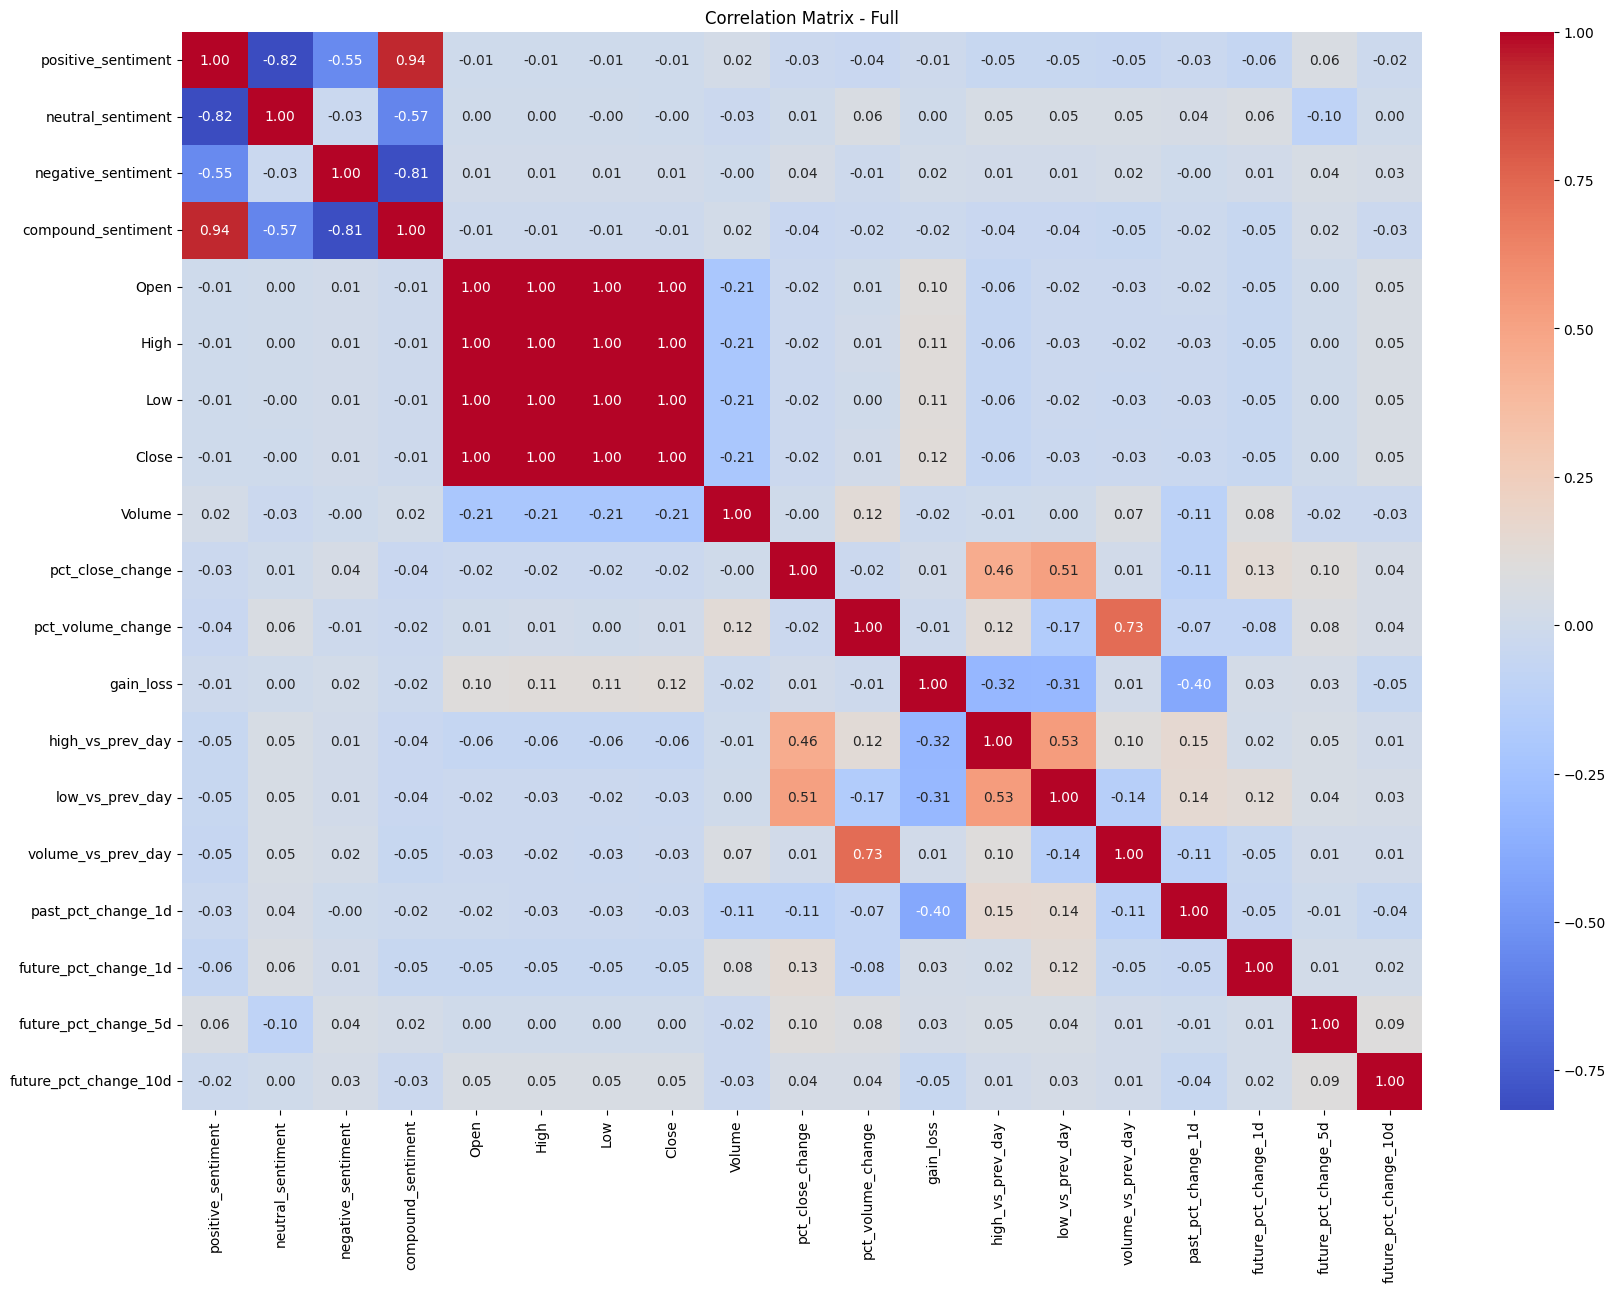

Heatmap saved to: images\correlation_matrix_heatmap.png


In [26]:
# Ensure the directory for images exists
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'correlation_matrix_heatmap.png')

# Heatmap for targeted correlation matrix
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Full")

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Heatmap saved to: {output_path}")

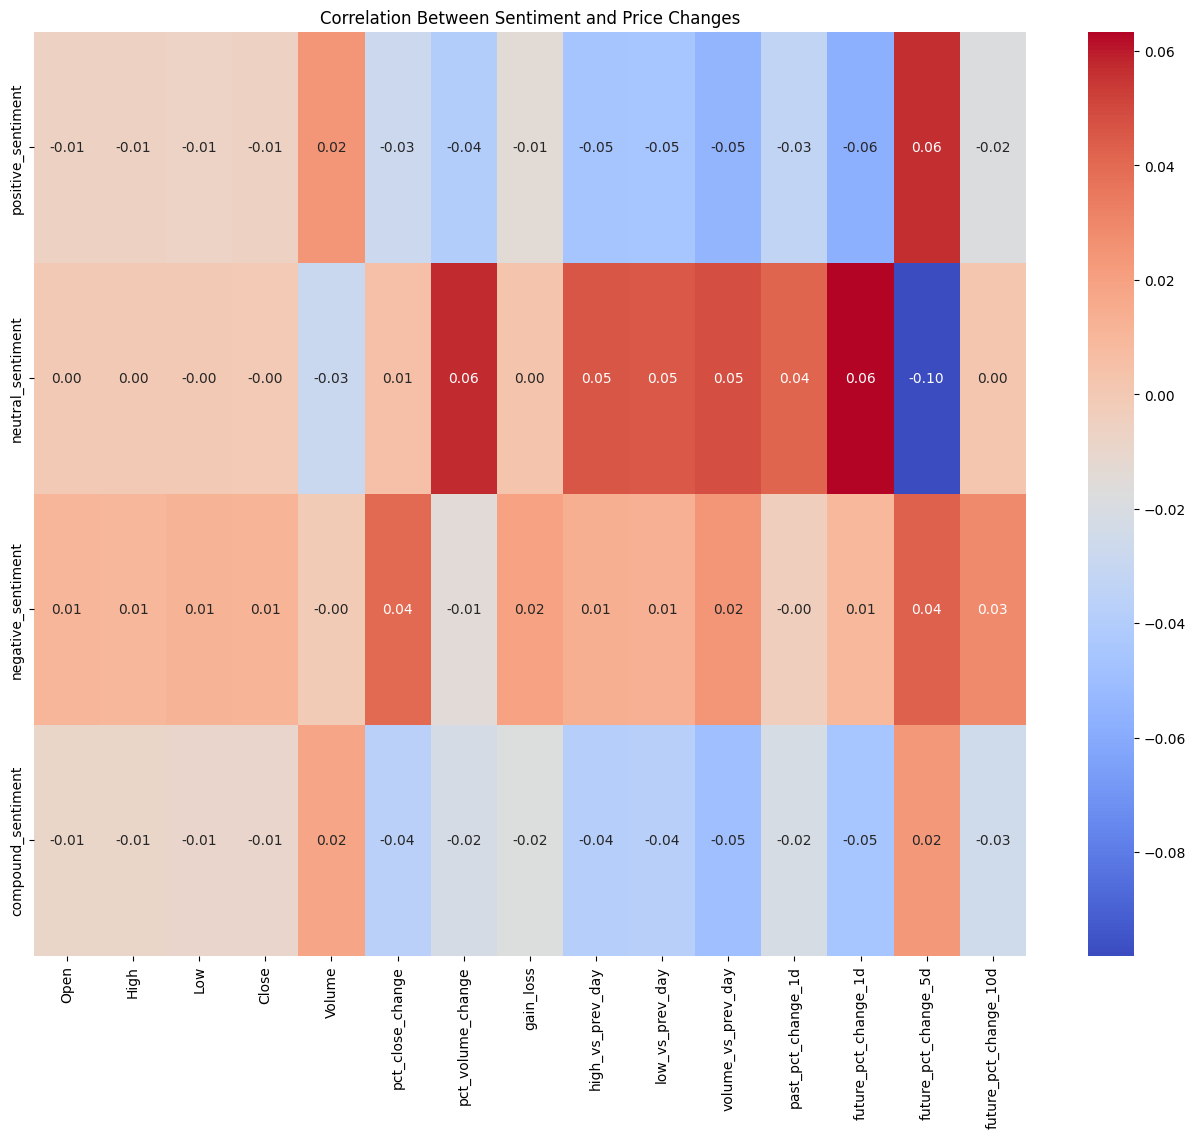

Heatmap saved to: images\sentiment_price_changes_correlation_heatmap.png


In [27]:
# Ensure the directory for images exists
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'sentiment_price_changes_correlation_heatmap.png')

# Heatmap for targeted correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(target_correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Sentiment and Price Changes")

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Heatmap saved to: {output_path}")

## Begin Modeling

In [28]:
# Define feature sets
sentiment_cols = ['positive_sentiment', 'neutral_sentiment', 'negative_sentiment', 'compound_sentiment']
numeric_features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 
    'pct_close_change', 'pct_volume_change', 
    'gain_loss', 'high_vs_prev_day', 'low_vs_prev_day', 'volume_vs_prev_day',
    'past_pct_change_1d'
]

# Combine numeric features with sentiment columns
X_features = sentiment_cols + numeric_features

# Define targets
target_1d = sentiment_stock_data['future_pct_change_1d']
target_5d = sentiment_stock_data['future_pct_change_5d']
target_10d = sentiment_stock_data['future_pct_change_10d']

# Train/test splits for each target
X_1d_train, X_1d_test, y_1d_train, y_1d_test = train_test_split(
    sentiment_stock_data[X_features], target_1d, test_size=0.2, random_state=42
)
X_5d_train, X_5d_test, y_5d_train, y_5d_test = train_test_split(
    sentiment_stock_data[X_features], target_5d, test_size=0.2, random_state=42
)
X_10d_train, X_10d_test, y_10d_train, y_10d_test = train_test_split(
    sentiment_stock_data[X_features], target_10d, test_size=0.2, random_state=42
)

# Confirm shapes of training and testing sets
print("Shapes of training and testing sets:")
print("1D Target: ", X_1d_train.shape, X_1d_test.shape, y_1d_train.shape, y_1d_test.shape)
print("5D Target: ", X_5d_train.shape, X_5d_test.shape, y_5d_train.shape, y_5d_test.shape)
print("10D Target: ", X_10d_train.shape, X_10d_test.shape, y_10d_train.shape, y_10d_test.shape)

Shapes of training and testing sets:
1D Target:  (452, 16) (113, 16) (452,) (113,)
5D Target:  (452, 16) (113, 16) (452,) (113,)
10D Target:  (452, 16) (113, 16) (452,) (113,)


### Create a Binary Target for Classification

In [29]:
# Define binary target for gain_loss
target_gain_loss = sentiment_stock_data['gain_loss']

# Train/test split for binary classification
X_gain_loss_train, X_gain_loss_test, y_gain_loss_train, y_gain_loss_test = train_test_split(
    sentiment_stock_data[X_features], target_gain_loss, test_size=0.2, random_state=42
)

# Confirm shapes of training and testing sets
print("Shapes of training and testing sets for gain_loss target:")
print("X_train: ", X_gain_loss_train.shape, "X_test: ", X_gain_loss_test.shape)
print("y_train: ", y_gain_loss_train.shape, "y_test: ", y_gain_loss_test.shape)


Shapes of training and testing sets for gain_loss target:
X_train:  (452, 16) X_test:  (113, 16)
y_train:  (452,) y_test:  (113,)


### Build Pre-Processing Pipeline

In [ ]:
# Unified create_pipeline function
def create_pipeline(model):
    """
    Create a machine learning pipeline with preprocessing and a given model.
    """
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X_features)
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

# Fits and evaluates regression models with GridSearchCV
def train_and_evaluate_pipeline_regression(X_train, X_test, y_train, y_test, model, param_grid, target_name):
    pipeline = create_pipeline(model)  
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)  

    # Extracts the best model and evaluates on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    # Displays results
    print(f"{target_name} - Best Params: {grid_search.best_params_}")
    print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")



# Fits and evaluates classification models with SMOTE for balancing
def train_and_evaluate_pipeline_classification(X_train, X_test, y_train, y_test, model, param_grid, target_name):
    smote = SMOTE(random_state=42) 
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    pipeline = create_pipeline(model)  
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)  

    # Extracts the best model and evaluates on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Displays results
    print(f"{target_name} - Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

positive_sentiment: 0.0053
neutral_sentiment: -0.0306
negative_sentiment: -0.0230
compound_sentiment: 0.0637
Open: 0.0169
High: 0.0740
Low: -0.0051
Close: -0.0342
Volume: 0.0474
pct_close_change: 0.0096
pct_volume_change: 0.0431
gain_loss: -0.0125
high_vs_prev_day: 0.0091
low_vs_prev_day: 0.0124
volume_vs_prev_day: 0.0035
past_pct_change_1d: -0.0705


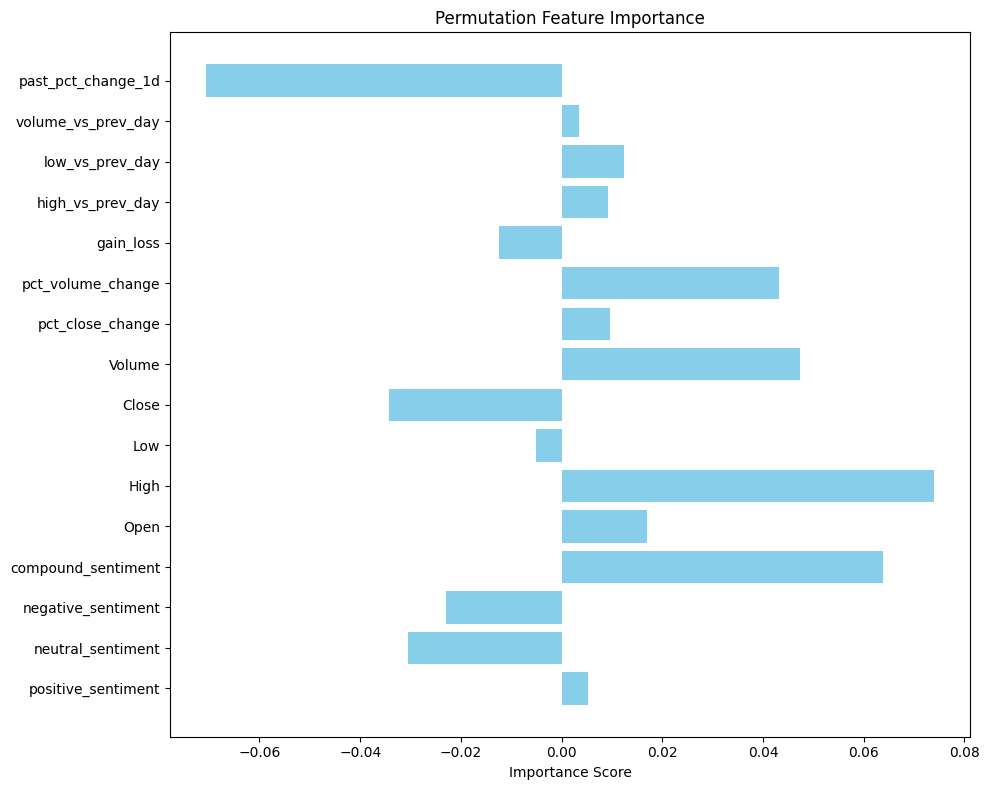

Plot saved to: images\permutation_importance.png


In [31]:
# Ensure the directory for images exists
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'permutation_importance.png')

# Train a Gradient Boosting Regressor for a target variable
model = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
model.fit(X_1d_train, y_1d_train)

# Compute Permutation Importance
perm_importance = permutation_importance(model, X_1d_test, y_1d_test, n_repeats=10, random_state=42)

# Display Feature Importances
for i, col in enumerate(X_1d_test.columns):
    print(f"{col}: {perm_importance.importances_mean[i]:.4f}")

# Plot Feature Importances
plt.figure(figsize=(10, 8))
plt.barh(X_1d_test.columns, perm_importance.importances_mean, color='skyblue')
plt.xlabel("Importance Score")
plt.title("Permutation Feature Importance")
plt.tight_layout()

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Plot saved to: {output_path}")

### Random Forest Regressor Model

In [32]:
# Configures Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Trains and evaluates for each target
train_and_evaluate_pipeline_regression(X_1d_train, X_1d_test, y_1d_train, y_1d_test, rf_model, rf_param_grid, "1-Day Target")
train_and_evaluate_pipeline_regression(X_5d_train, X_5d_test, y_5d_train, y_5d_test, rf_model, rf_param_grid, "5-Day Target")
train_and_evaluate_pipeline_regression(X_10d_train, X_10d_test, y_10d_train, y_10d_test, rf_model, rf_param_grid, "10-Day Target")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
1-Day Target - Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
R²: -0.0026, RMSE: 0.9453
Fitting 3 folds for each of 36 candidates, totalling 108 fits
5-Day Target - Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 300}
R²: 0.0647, RMSE: 0.9758
Fitting 3 folds for each of 36 candidates, totalling 108 fits
10-Day Target - Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
R²: 0.0674, RMSE: 0.9770


### Random Forest Classifier Model

In [33]:
# Configures Random Forest Classifier
rf_clf_model = RandomForestClassifier(random_state=42)
rf_clf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Train and evaluate using the binary target `gain_loss`
train_and_evaluate_pipeline_classification(
    X_gain_loss_train, X_gain_loss_test, 
    y_gain_loss_train, y_gain_loss_test, 
    rf_clf_model, rf_clf_param_grid, "Gain Loss Target"
)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Gain Loss Target - Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        63

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



### Neural Network Model

In [34]:
# Configures Neural Network
nn_model = MLPRegressor(random_state=42, max_iter=5000)
nn_param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001],
    'model__learning_rate': ['constant', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.0005]
}

# Trains and evaluates for each target
train_and_evaluate_pipeline_regression(X_1d_train, X_1d_test, y_1d_train, y_1d_test, nn_model, nn_param_grid, "1-Day Target")
train_and_evaluate_pipeline_regression(X_5d_train, X_5d_test, y_5d_train, y_5d_test, nn_model, nn_param_grid, "5-Day Target")
train_and_evaluate_pipeline_regression(X_10d_train, X_10d_test, y_10d_train, y_10d_test, nn_model, nn_param_grid, "10-Day Target")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
1-Day Target - Best Params: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.0005}
R²: -0.4908, RMSE: 1.1527
Fitting 3 folds for each of 48 candidates, totalling 144 fits
5-Day Target - Best Params: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.0005}
R²: -0.0200, RMSE: 1.0190
Fitting 3 folds for each of 48 candidates, totalling 144 fits
10-Day Target - Best Params: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate': 'constant', 'model__learning_rate_init': 0.0005}
R²: -0.5735, RMSE: 1.2690


### Gradient Boosting (Ensemble) Model

In [35]:
# Configures Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

# Trains and evaluates for each target
train_and_evaluate_pipeline_regression(X_1d_train, X_1d_test, y_1d_train, y_1d_test, gb_model, gb_param_grid, "1-Day Target")
train_and_evaluate_pipeline_regression(X_5d_train, X_5d_test, y_5d_train, y_5d_test, gb_model, gb_param_grid, "5-Day Target")
train_and_evaluate_pipeline_regression(X_10d_train, X_10d_test, y_10d_train, y_10d_test, gb_model, gb_param_grid, "10-Day Target")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
1-Day Target - Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
R²: -0.0546, RMSE: 0.9695
Fitting 3 folds for each of 8 candidates, totalling 24 fits
5-Day Target - Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
R²: -0.0279, RMSE: 1.0230
Fitting 3 folds for each of 8 candidates, totalling 24 fits
10-Day Target - Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
R²: 0.0750, RMSE: 0.9730


### Support Vector Machine Model

In [36]:
# SVR model and hyperparameters
svr_model = SVR()
svr_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto'],
    'model__epsilon': [0.1, 0.2, 0.5]
}

# Train and evaluate SVR for each target
train_and_evaluate_pipeline_regression(X_1d_train, X_1d_test, y_1d_train, y_1d_test, svr_model, svr_param_grid, "1-Day Target")
train_and_evaluate_pipeline_regression(X_5d_train, X_5d_test, y_5d_train, y_5d_test, svr_model, svr_param_grid, "5-Day Target")
train_and_evaluate_pipeline_regression(X_10d_train, X_10d_test, y_10d_train, y_10d_test, svr_model, svr_param_grid, "10-Day Target")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
1-Day Target - Best Params: {'model__C': 0.1, 'model__epsilon': 0.5, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
R²: 0.0264, RMSE: 0.9315
Fitting 3 folds for each of 36 candidates, totalling 108 fits
5-Day Target - Best Params: {'model__C': 0.1, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
R²: -0.0207, RMSE: 1.0194
Fitting 3 folds for each of 36 candidates, totalling 108 fits
10-Day Target - Best Params: {'model__C': 0.1, 'model__epsilon': 0.5, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
R²: 0.0029, RMSE: 1.0102


### Granger Causality Test

In [37]:
# Function to run Granger Causality Test
def run_granger_causality(data, target_col, feature_col, max_lag):
    """
    Perform Granger Causality Test for a given target and feature column.
    """
    test_data = data[[feature_col, target_col]].dropna()  # Prepare test data
    results = grangercausalitytests(test_data, maxlag=max_lag)  # Run test

    best_lag = None
    best_p_value = float('inf')

    # Extract and display results
    for lag, result in results.items():
        test_stat = result[0]['ssr_chi2test'][0]
        p_value = result[0]['ssr_chi2test'][1]
        print(f"Lag {lag}: Test Statistic = {test_stat:.4f}, p-value = {p_value:.4f}")
        if p_value < best_p_value:
            best_p_value = p_value
            best_lag = lag

    return best_lag, best_p_value

# Run and display results
feature = 'compound_sentiment'
target = 'future_pct_change_1d'
best_lag, best_p_value = run_granger_causality(sentiment_stock_data, target, feature, max_lag=10)

if best_lag is not None:
    print(f"\nBest Lag: {best_lag} (p-value = {best_p_value:.4f})")
else:
    print("\nNo significant causality found within the tested lags.")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3565  , p=0.5507  , df_denom=561, df_num=1
ssr based chi2 test:   chi2=0.3584  , p=0.5494  , df=1
likelihood ratio test: chi2=0.3583  , p=0.5495  , df=1
parameter F test:         F=0.3565  , p=0.5507  , df_denom=561, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1179  , p=0.3277  , df_denom=558, df_num=2
ssr based chi2 test:   chi2=2.2557  , p=0.3237  , df=2
likelihood ratio test: chi2=2.2512  , p=0.3245  , df=2
parameter F test:         F=1.1179  , p=0.3277  , df_denom=558, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7275  , p=0.5359  , df_denom=555, df_num=3
ssr based chi2 test:   chi2=2.2099  , p=0.5300  , df=3
likelihood ratio test: chi2=2.2056  , p=0.5308  , df=3
parameter F test:         F=0.7275  , p=0.5359  , df_denom=555, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6725  , p=0.6113  